In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data
df = pd.read_csv('Data/logs.csv')

In [3]:
df.head()

,timestamp,observed_timestamp,id,trace_id,span_id,trace_flags,severity_text,severity_number,body,resources_string_key,resources_string_value,attributes_string_key,attributes_string_value,attributes_int64_key,attributes_int64_value,attributes_float64_key,attributes_float64_value,attributes_bool_key,attributes_bool_value
0,1714750043000000000,1714750043213385385,2fxVpIEdOkEKkTsSs1rPt7FEH2u,NaN,NaN,0,NaN,0,"[2024-05-03 15:27:23,209] INFO [Controller 1] ...",[],[],"['container_id','container_name']","['opsfree','kafka']",[],[],[],[],[],[]
1,1714750043000000000,1714750043215915002,2fxVpIEdOkEKkTsSs1rPt7FEH2v,NaN,NaN,0,NaN,0,"[2024-05-03 15:27:23,212] INFO [Controller 1] ...",[],[],"['container_name','container_id']","['kafka','opsfree']",[],[],[],[],[],[]
2,1714750043000000000,1714750043216028292,2fxVpIEdOkEKkTsSs1rPt7FEH2w,NaN,NaN,0,NaN,0,"[2024-05-03 15:27:23,212] INFO [Controller 1] ...",[],[],"['container_id','container_name']","['opsfree','kafka']",[],[],[],[],[],[]
3,1714750043000000000,1714750043216760392,2fxVpIEdOkEKkTsSs1rPt7FEH2x,NaN,NaN,0,NaN,0,"[2024-05-03 15:27:23,212] INFO [Controller 1] ...",[],[],"['container_id','container_name']","['opsfree','kafka']",[],[],[],[],[],[]
4,1714750043000000000,1714750043216854493,2fxVpIEdOkEKkTsSs1rPt7FEH2y,NaN,NaN,0,NaN,0,"[2024-05-03 15:27:23,212] INFO [Controller 1] ...",[],[],"['container_id','container_name']","['opsfree','kafka']",[],[],[],[],[],[]


In [4]:
print(df.dtypes)

timestamp                     int64
 observed_timestamp           int64
 id                          object
 trace_id                    object
 span_id                     object
 trace_flags                  int64
 severity_text               object
 severity_number              int64
 body                        object
 resources_string_key        object
 resources_string_value      object
 attributes_string_key       object
 attributes_string_value     object
 attributes_int64_key        object
 attributes_int64_value      object
 attributes_float64_key      object
 attributes_float64_value    object
 attributes_bool_key         object
 attributes_bool_value       object
dtype: object


In [5]:
df.shape

(134961, 19)

In [6]:
df.size

2564259

In [7]:
# Strip any leading or trailing whitespace from column names
df.columns = df.columns.str.strip()

In [8]:
# Convert POSIX timestamps to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')
df['observed_timestamp'] = pd.to_datetime(df['observed_timestamp'], unit='ns')

In [9]:
print("\nConverted timestamps:")
print(df[['timestamp', 'observed_timestamp']].head())


Converted timestamps:
            timestamp            observed_timestamp
0 2024-05-03 15:27:23 2024-05-03 15:27:23.213385385
1 2024-05-03 15:27:23 2024-05-03 15:27:23.215915002
2 2024-05-03 15:27:23 2024-05-03 15:27:23.216028292
3 2024-05-03 15:27:23 2024-05-03 15:27:23.216760392
4 2024-05-03 15:27:23 2024-05-03 15:27:23.216854493


In [10]:
# Calculate and display missing values percentage
missing_percentage = df.isnull().sum() / len(df) * 100
missing_percentage = missing_percentage[missing_percentage > 0]
print("\nMissing values percentage:")
print(missing_percentage)


Missing values percentage:
trace_id         91.961381
span_id          91.961381
severity_text    91.956936
body              0.004446
dtype: float64


In [11]:

# Handle missing values
df['trace_id'].fillna('Unknown', inplace=True)
df['span_id'].fillna('Unknown', inplace=True)
df['severity_text'].fillna('Unknown', inplace=True)
df['body'].fillna('', inplace=True)

In [12]:
# Select numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [13]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nCategorical columns:")


Categorical columns:


In [14]:
categorical_columns

['id',
 'trace_id',
 'span_id',
 'severity_text',
 'body',
 'resources_string_key',
 'resources_string_value',
 'attributes_string_key',
 'attributes_string_value',
 'attributes_int64_key',
 'attributes_int64_value',
 'attributes_float64_key',
 'attributes_float64_value',
 'attributes_bool_key',
 'attributes_bool_value']

In [15]:
# Convert categorical columns to numerical using Label Encoding
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))


In [16]:
# Check data types after encoding
print("\nData types after encoding:")
print(df.dtypes)


Data types after encoding:
timestamp                   datetime64[ns]
observed_timestamp          datetime64[ns]
id                                   int32
trace_id                             int32
span_id                              int32
trace_flags                          int64
severity_text                        int32
severity_number                      int64
body                                 int32
resources_string_key                 int32
resources_string_value               int32
attributes_string_key                int32
attributes_string_value              int32
attributes_int64_key                 int32
attributes_int64_value               int32
attributes_float64_key               int32
attributes_float64_value             int32
attributes_bool_key                  int32
attributes_bool_value                int32
dtype: object


In [17]:
# Calculate and visualize correlation matrix
corr_matrix = df.corr()

In [18]:
corr_matrix

,timestamp,observed_timestamp,id,trace_id,span_id,trace_flags,severity_text,severity_number,body,resources_string_key,resources_string_value,attributes_string_key,attributes_string_value,attributes_int64_key,attributes_int64_value,attributes_float64_key,attributes_float64_value,attributes_bool_key,attributes_bool_value
timestamp,1.000000,0.999999,0.968884,-0.002328,-0.001200,0.005119,-0.000925,0.005730,-0.000136,-0.007106,-0.007106,0.004548,-0.004250,NaN,NaN,NaN,NaN,NaN,NaN
observed_timestamp,0.999999,1.000000,0.968878,-0.002716,-0.001614,0.006156,-0.001951,0.006767,0.000024,-0.007999,-0.007999,0.005372,-0.004906,NaN,NaN,NaN,NaN,NaN,NaN
id,0.968884,0.968878,1.000000,-0.000946,0.000666,0.000161,0.004679,0.001004,0.003789,-0.002771,-0.002771,0.000587,0.001124,NaN,NaN,NaN,NaN,NaN,NaN
trace_id,-0.002328,-0.002716,-0.000946,1.000000,0.158031,-0.366538,0.362752,-0.365934,-0.055025,0.342869,0.342869,-0.306721,0.191000,NaN,NaN,NaN,NaN,NaN,NaN
span_id,-0.001200,-0.001614,0.000666,0.158031,1.000000,-0.392070,0.385903,-0.391893,-0.059115,0.373129,0.373129,-0.331766,0.482921,NaN,NaN,NaN,NaN,NaN,NaN
trace_flags,0.005119,0.006156,0.000161,-0.366538,-0.392070,1.000000,-0.986493,0.999056,0.150930,-0.943453,-0.943453,0.841438,-0.488549,NaN,NaN,NaN,NaN,NaN,NaN
severity_text,-0.000925,-0.001951,0.004679,0.362752,0.385903,-0.986493,1.000000,-0.980345,-0.148627,0.926913,0.926913,-0.828061,0.489938,NaN,NaN,NaN,NaN,NaN,NaN
severity_number,0.005730,0.006767,0.001004,-0.365934,-0.391893,0.999056,-0.980345,1.000000,0.150890,-0.944024,-0.944024,0.841665,-0.487304,NaN,NaN,NaN,NaN,NaN,NaN
body,-0.000136,0.000024,0.003789,-0.055025,-0.059115,0.150930,-0.148627,0.150890,1.000000,-0.143054,-0.143054,0.129611,-0.096317,NaN,NaN,NaN,NaN,NaN,NaN
resources_string_key,-0.007106,-0.007999,-0.002771,0.342869,0.373129,-0.943453,0.926913,-0.944024,-0.143054,1.000000,1.000000,-0.857414,0.278960,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))


In [20]:
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False,  T

In [21]:

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

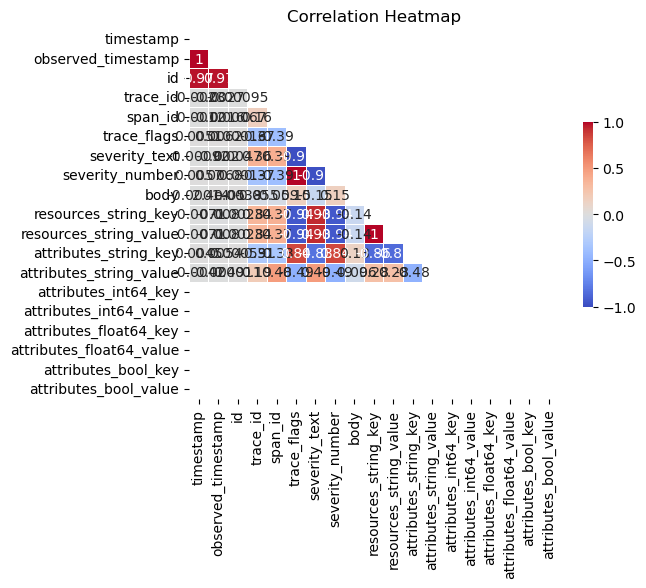

In [22]:
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap')
plt.show()

In [23]:
df.describe()

,timestamp,observed_timestamp,id,trace_id,span_id,trace_flags,severity_text,severity_number,body,resources_string_key,resources_string_value,attributes_string_key,attributes_string_value,attributes_int64_key,attributes_int64_value,attributes_float64_key,attributes_float64_value,attributes_bool_key,attributes_bool_value
count,134961,134961,134961.000000,134961.000000,134961.000000,134961.000000,134961.000000,134961.000000,134961.000000,134961.000000,134961.000000,134961.000000,134961.000000,134961.0,134961.0,134961.0,134961.0,134961.0,134961.0
mean,2024-05-03 14:39:00.462740224,2024-05-03 14:39:01.467735040,67480.000000,6301.455798,6662.741236,0.080386,0.920547,0.725832,48632.368884,1.880432,1.880432,0.373389,5358.265210,0.0,0.0,0.0,0.0,0.0,0.0
min,2024-05-03 13:28:20,2024-05-03 13:28:20.234460331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,2024-05-03 14:18:16,2024-05-03 14:18:16.901005568,33740.000000,6400.000000,6774.000000,0.000000,1.000000,0.000000,29260.000000,2.000000,2.000000,0.000000,5586.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,2024-05-03 14:46:29,2024-05-03 14:46:29.902290176,67480.000000,6400.000000,6774.000000,0.000000,1.000000,0.000000,51152.000000,2.000000,2.000000,0.000000,5587.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,2024-05-03 14:58:41,2024-05-03 14:58:43.206360320,101220.000000,6400.000000,6774.000000,0.000000,1.000000,0.000000,65185.000000,2.000000,2.000000,1.000000,5598.000000,0.0,0.0,0.0,0.0,0.0,0.0
max,2024-05-03 15:28:02,2024-05-03 15:28:02.232925545,134960.000000,10341.000000,10783.000000,1.000000,2.000000,13.000000,97643.000000,2.000000,2.000000,3.000000,5609.000000,0.0,0.0,0.0,0.0,0.0,0.0
std,NaN,NaN,38960.029177,909.337784,959.808426,0.271891,0.272247,2.455836,25965.612328,0.428424,0.428424,0.742552,725.126682,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df

,timestamp,observed_timestamp,id,trace_id,span_id,trace_flags,severity_text,severity_number,body,resources_string_key,resources_string_value,attributes_string_key,attributes_string_value,attributes_int64_key,attributes_int64_value,attributes_float64_key,attributes_float64_value,attributes_bool_key,attributes_bool_value
0,2024-05-03 15:27:23,2024-05-03 15:27:23.213385385,134905,6400,6774,0,1,0,76909,2,2,0,5596,0,0,0,0,0,0
1,2024-05-03 15:27:23,2024-05-03 15:27:23.215915002,134906,6400,6774,0,1,0,76913,2,2,1,5582,0,0,0,0,0,0
2,2024-05-03 15:27:23,2024-05-03 15:27:23.216028292,134907,6400,6774,0,1,0,76911,2,2,0,5596,0,0,0,0,0,0
3,2024-05-03 15:27:23,2024-05-03 15:27:23.216760392,134908,6400,6774,0,1,0,76912,2,2,0,5596,0,0,0,0,0,0
4,2024-05-03 15:27:23,2024-05-03 15:27:23.216854493,134909,6400,6774,0,1,0,76910,2,2,0,5596,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134956,2024-05-03 15:27:12,2024-05-03 15:27:12.730304201,134900,6400,6774,0,1,0,76906,2,2,0,5596,0,0,0,0,0,0
134957,2024-05-03 15:27:15,2024-05-03 15:27:15.299281331,134901,6400,6774,0,1,0,14352,2,2,0,5590,0,0,0,0,0,0
134958,2024-05-03 15:27:15,2024-05-03 15:27:15.300145048,134902,6400,6774,0,1,0,14353,2,2,0,5590,0,0,0,0,0,0
134959,2024-05-03 15:27:16,2024-05-03 15:27:16.205462095,134903,6400,6774,0,1,0,76907,2,2,0,5596,0,0,0,0,0,0


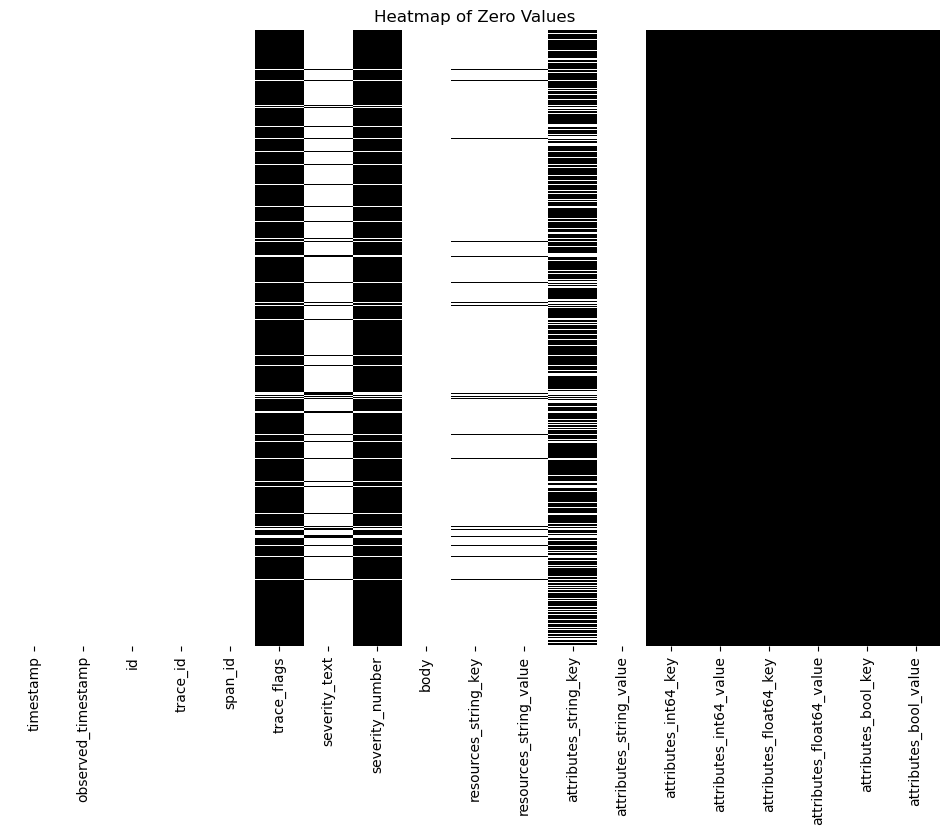

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot heatmap of zero values
plt.figure(figsize=(12, 8))
sns.heatmap(df == 0, cbar=False, cmap='binary', yticklabels=False)
plt.title('Heatmap of Zero Values')
plt.show()

In [26]:
columns_of_interest = [
    'attributes_int64_key', 'attributes_int64_value',
    'attributes_float64_key', 'attributes_float64_value',
    'attributes_bool_key', 'attributes_bool_value'
]

In [27]:
zero_percentage_of_interest = (df[columns_of_interest] == 0).sum() / len(df) * 100

In [28]:
zero_percentage_of_interest 

attributes_int64_key        100.0
attributes_int64_value      100.0
attributes_float64_key      100.0
attributes_float64_value    100.0
attributes_bool_key         100.0
attributes_bool_value       100.0
dtype: float64

In [29]:
zero_only_columns = zero_percentage_of_interest[zero_percentage_of_interest == 100].index

In [30]:
df_cleaned = df.drop(columns=zero_only_columns)

In [31]:
df_cleaned 

,timestamp,observed_timestamp,id,trace_id,span_id,trace_flags,severity_text,severity_number,body,resources_string_key,resources_string_value,attributes_string_key,attributes_string_value
0,2024-05-03 15:27:23,2024-05-03 15:27:23.213385385,134905,6400,6774,0,1,0,76909,2,2,0,5596
1,2024-05-03 15:27:23,2024-05-03 15:27:23.215915002,134906,6400,6774,0,1,0,76913,2,2,1,5582
2,2024-05-03 15:27:23,2024-05-03 15:27:23.216028292,134907,6400,6774,0,1,0,76911,2,2,0,5596
3,2024-05-03 15:27:23,2024-05-03 15:27:23.216760392,134908,6400,6774,0,1,0,76912,2,2,0,5596
4,2024-05-03 15:27:23,2024-05-03 15:27:23.216854493,134909,6400,6774,0,1,0,76910,2,2,0,5596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134956,2024-05-03 15:27:12,2024-05-03 15:27:12.730304201,134900,6400,6774,0,1,0,76906,2,2,0,5596
134957,2024-05-03 15:27:15,2024-05-03 15:27:15.299281331,134901,6400,6774,0,1,0,14352,2,2,0,5590
134958,2024-05-03 15:27:15,2024-05-03 15:27:15.300145048,134902,6400,6774,0,1,0,14353,2,2,0,5590
134959,2024-05-03 15:27:16,2024-05-03 15:27:16.205462095,134903,6400,6774,0,1,0,76907,2,2,0,5596


In [32]:
df_cleaned.corr()

,timestamp,observed_timestamp,id,trace_id,span_id,trace_flags,severity_text,severity_number,body,resources_string_key,resources_string_value,attributes_string_key,attributes_string_value
timestamp,1.000000,0.999999,0.968884,-0.002328,-0.001200,0.005119,-0.000925,0.005730,-0.000136,-0.007106,-0.007106,0.004548,-0.004250
observed_timestamp,0.999999,1.000000,0.968878,-0.002716,-0.001614,0.006156,-0.001951,0.006767,0.000024,-0.007999,-0.007999,0.005372,-0.004906
id,0.968884,0.968878,1.000000,-0.000946,0.000666,0.000161,0.004679,0.001004,0.003789,-0.002771,-0.002771,0.000587,0.001124
trace_id,-0.002328,-0.002716,-0.000946,1.000000,0.158031,-0.366538,0.362752,-0.365934,-0.055025,0.342869,0.342869,-0.306721,0.191000
span_id,-0.001200,-0.001614,0.000666,0.158031,1.000000,-0.392070,0.385903,-0.391893,-0.059115,0.373129,0.373129,-0.331766,0.482921
trace_flags,0.005119,0.006156,0.000161,-0.366538,-0.392070,1.000000,-0.986493,0.999056,0.150930,-0.943453,-0.943453,0.841438,-0.488549
severity_text,-0.000925,-0.001951,0.004679,0.362752,0.385903,-0.986493,1.000000,-0.980345,-0.148627,0.926913,0.926913,-0.828061,0.489938
severity_number,0.005730,0.006767,0.001004,-0.365934,-0.391893,0.999056,-0.980345,1.000000,0.150890,-0.944024,-0.944024,0.841665,-0.487304
body,-0.000136,0.000024,0.003789,-0.055025,-0.059115,0.150930,-0.148627,0.150890,1.000000,-0.143054,-0.143054,0.129611,-0.096317
resources_string_key,-0.007106,-0.007999,-0.002771,0.342869,0.373129,-0.943453,0.926913,-0.944024,-0.143054,1.000000,1.000000,-0.857414,0.278960


In [33]:
corr_matrix=df_cleaned.corr()

In [34]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

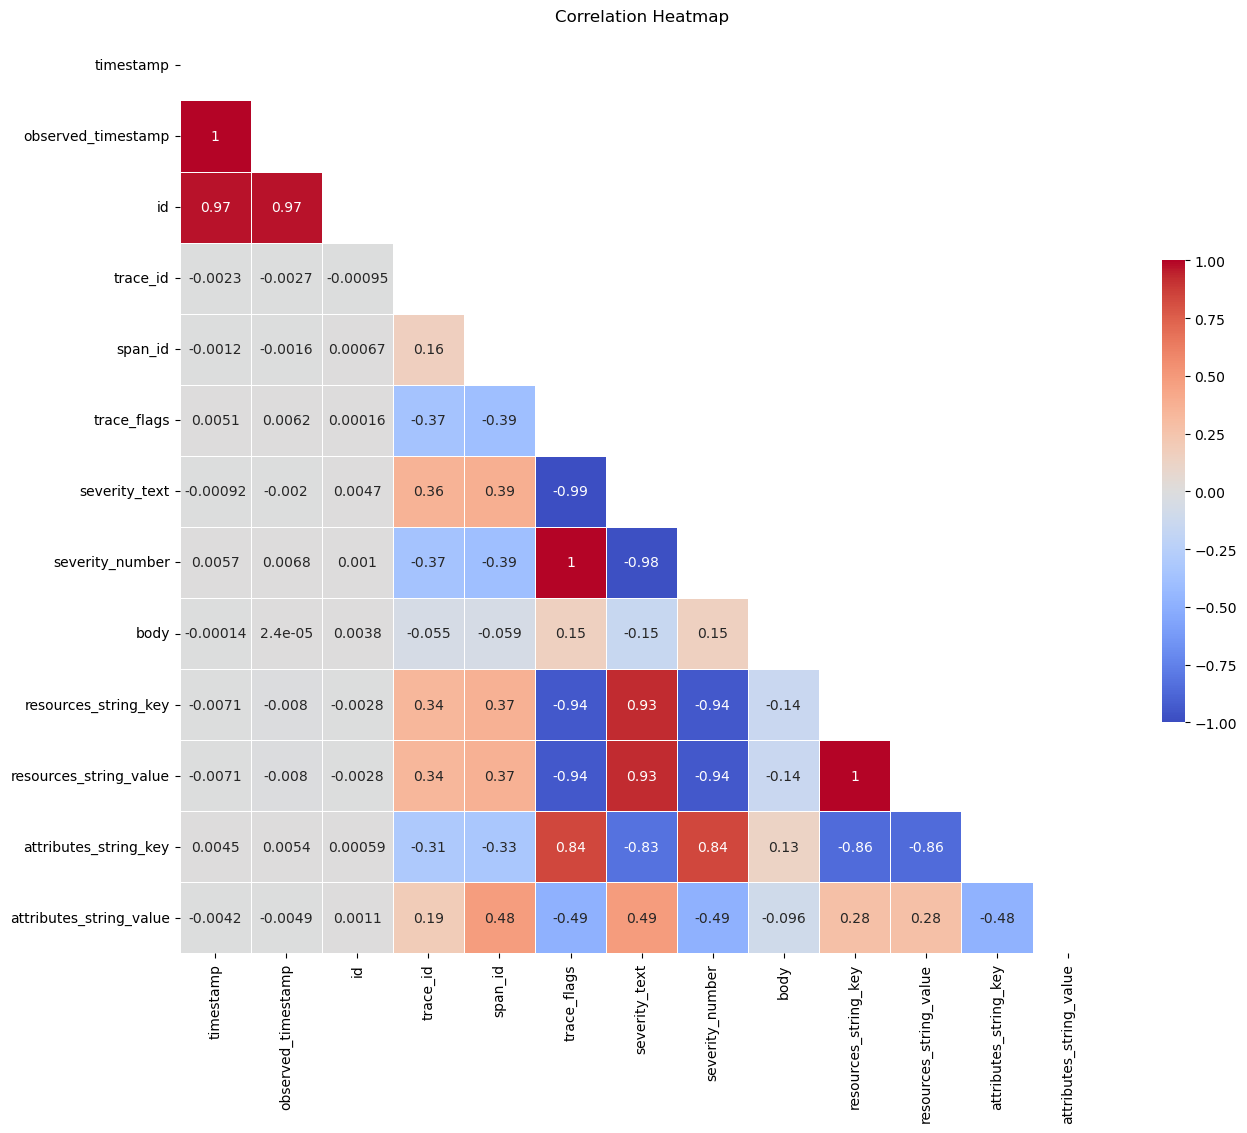

In [35]:
plt.figure(figsize=(15, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap')
plt.show()

In [36]:
import nltk

# Download the punkt tokenizer model
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\imaba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
# NLP Analysis on 'body' 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

In [38]:
# Tokenization and removing stop words
def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

In [39]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [40]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove punctuation and lower the tokens
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [41]:
print(df_cleaned['body'].dtype)

int32


In [42]:
print(df_cleaned['body'].head())


0    76909
1    76913
2    76911
3    76912
4    76910
Name: body, dtype: int32


In [43]:
# Convert the 'body' column to strings
df_cleaned['body'] = df_cleaned['body'].astype(str)


In [44]:
# Apply the preprocessing function to the 'body' column
df_cleaned['body_processed'] = df_cleaned['body'].apply(preprocess_text)


In [45]:
# Show the processed body text
df_cleaned[['body', 'body_processed']].head()

,body,body_processed
0,76909,
1,76913,
2,76911,
3,76912,
4,76910,


In [49]:
pip install textblob

  Obtaining dependency information for textblob from https://files.pythonhosted.org/packages/02/07/5fd2945356dd839974d3a25de8a142dc37293c21315729a41e775b5f3569/textblob-0.18.0.post0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
   -- ------------------------------------ 41.0/626.3 kB 326.8 kB/s eta 0:00:02
   -- ------------------------------------ 41.0/626.3 kB 326.8 kB/s eta 0:00:02
   ------ ------------------------------- 112.6/626.3 kB 547.6 kB/s eta 0:00:01
   ------ ------------------------------- 112.6/626.3 kB 547.6 kB/s eta 0:00:01
   ------------- ------------------------ 225.3/626.3 kB 724.0 kB/s eta 0:00:01
   ------------- ------------------------ 225.3/626.3 kB 724.0 kB/s eta 0:00:01
   -------------- ----------------------- 245.8/626.3 kB 602.4 kB/s eta 0:00:01
   --------------

In [51]:
from textblob import TextBlob

In [52]:
# Function to get the sentiment score
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [53]:

df_cleaned['sentiment_score'] = df_cleaned['body_processed'].apply(get_sentiment)

In [54]:
c

,body_processed,sentiment_score
0,,0.0
1,,0.0
2,,0.0
3,,0.0
4,,0.0
